In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import string
import re
import numpy as np
from numpy.linalg import norm
import pickle as pk
import time
from fuzzywuzzy import fuzz
import nltk
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords 
import gensim
import gensim.downloader as api
from gensim.models import Word2Vec, KeyedVectors
from scipy.cluster import  hierarchy
import scipy.spatial.distance as D
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

### Load pretrained Word2Vec

In [ ]:
#model = api.load("word2vec-google-news-300")

In [3]:
model_path = api.load("word2vec-google-news-300", return_path=True)

In [4]:
w2v = KeyedVectors.load_word2vec_format(model_path, binary= True)

In [5]:
# normalized model so we can use wmdistance later
w2v_norm = KeyedVectors.load_word2vec_format(model_path, binary= True)
w2v_norm.init_sims(replace=True)

### Load labeled data

In [225]:
labeled = pd.read_csv('../data/traning_v5.csv') 
labeled = labeled.dropna()
labeled = labeled.drop_duplicates()
labeled = shuffle(labeled)
labeled = labeled.head(15000).reset_index(drop = True)
labeled = labeled.drop(columns = ['Unnamed: 0'])

In [226]:
labeled.head(4)

,str_1,str_2,Y
0,"7067 Dahle Alley, Kilwinning, England","7067 Dahle Alley, Kilwinning, ENG, DN22, UK",1
1,"6291 Sunfield Avenue, Chadds Ford, California","94 Thompson Road, Creston, TX 60849, USA",0
2,"Callington, England","Callington, GB",1
3,"8391 Village Dr Drive, Coppull, Northern Ireland","8391 Village Dr Drive, Coppull, NIR, BT2",1


### Tokenize and add bi grams

In [8]:
table = str.maketrans('', '', string.punctuation.replace('#', '').replace('&', ''))
stop_words = set(stopwords.words('english')) 
    # After trying different preprocessing combinations, I decided not to filter out stops words, 
    # and keept '#' and '&' since they can help defining a string in our specific case 
def get_tokens(x): 
    x = re.sub(r'\d', '#', x).lower()
    tokens = word_tokenize(x)
    tokens = [w.translate(table) for w in tokens]
    tokens = [x for x in tokens if x != '']
    return tokens

bi_gram_list = [x for x in w2v.index2word if re.search('(_){1,}', x)]
bi_gram_list_lower = [x.lower() for x in bi_gram_list]
def get_bi_gram(x): 
    return_list = []
    last_flag = False
    for i in range(len(x)-1): 
        current_token = x[i]
        current_bigram = x[i]+'_'+x[i+1]
        if current_token != '#' and current_bigram in bi_gram_list_lower:
            matched_idx = bi_gram_list_lower.index(current_bigram)
            current_token = bi_gram_list[matched_idx]
            if i+1 == len(x)-1: 
                last_flag = True
        return_list.append(current_token)
    if last_flag == False: 
        return_list.append(x[-1])
    return return_list

### Get word2vec vectors from pretrained model

In [9]:
model_vocab = w2v.vocab
# get vector per string
def get_vector(x):
    agg_vector = []
    for token in x: 
        if token in model_vocab: 
            v = w2v[token]  
        elif token.capitalize() in model_vocab:
            v = w2v[token.capitalize()] 
        else: 
            #print (token, 'NOT FOUND!')
            v = w2v['#'] # assign unknown words (usually random letters in a serial number) to # to skew the vector
        agg_vector.append(v)
    agg_vector = np.array(agg_vector)
    agg_vector = np.mean(agg_vector, axis = 0)
    return agg_vector

### Add more features

In [10]:
# Adding word and character count, and a flag for possible company name
company_str = ['corporation', 'inc', 'co', 'corp', 'cooperatives', 'ltd', 'limited', 'company', \
               'lp', 'incorporated', 'international', 'association']
def get_word_cnt(x): 
    return len(x)

def get_char_cnt(x): 
    return len(''.join(x))

def get_company_flag(x): 
    if any(w in company_str for w in x): 
        return 1
    else: return 0 
    
def get_digits_ratio(x): 
    x = x.replace(' ', '')
    digit_count = 0
    for c in x: 
        if c.isdigit(): 
            digit_count += 1
    return digit_count/len(x)

def concat_features(row): 
    concat_list = np.array([row['word_count'], row['char_count'], row['company_str'], row['digital_ratio'], row['punctuation_ratio']])
    new_concat_list = np.append(row['vecter_300'], concat_list)
    return new_concat_list

### Normalize matrix

In [11]:
def scale_mat(vec_matrix,preprocess_type):
    if preprocess_type == 'MinMax':
        scale = preprocessing.MinMaxScaler().fit(vec_matrix)  
    if preprocess_type == 'Standard':
        scale = preprocessing.StandardScaler().fit(vec_matrix)
    vals = scale.transform(vec_matrix)
    return vals

In [12]:
# PCA reduce dimensions
sklearn_pca = PCA(n_components = 2)

### Split training and testing data

In [229]:
train, test = train_test_split(labeled, test_size=0.01)
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)

In [230]:
print (train.shape, test.shape)

(14850, 3) (150, 3)


### Process data

In [15]:
# preprocess - input dataset with str_1 and str_2
def concat_features(row, col): 
    concat_list = np.array([row[col+'_word_count'], row[col+'_char_count'], row[col+'_company_flag'], row[col+'_digit_ratio']])
    new_concat_list = np.append(row[col+'_vector_300'], concat_list)
    return new_concat_list

# compare first word
def first_match_boo(str_1, str_2): 
    str_1 = str_1.split()
    str_2 = str_2.split()
    if str_1[0] == str_2[0]: 
        return 1
    else: 
        return 0

# return a list of characteristics features, input data with str_1 and str2 
def get_char_features_labled(updated_df): 
    return_list = []
    for idx, row in updated_df.iterrows(): 
        append_list = []
        append_list.append(first_match_boo(row['str_1'], row['str_2']))
        append_list.append(row['str_1_word_count']-row['str_2_word_count']) # word count difference
        append_list.append(row['str_1_char_count']-row['str_2_char_count']) # character count difference
        append_list.append(len(set(row['str_1_token']).intersection(set(row['str_2_token'])))) # common word
        append_list.append(fuzz.ratio(row['str_1_clean_string'], row['str_2_clean_string'])) # fuzz ratio
        append_list.append(fuzz.partial_ratio(row['str_1_clean_string'], row['str_2_clean_string'])) # fuzz partical
        append_list.append(fuzz.token_set_ratio(row['str_1_clean_string'], row['str_2_clean_string'])) # fuzz token set
        append_list.append(fuzz.partial_token_sort_ratio(row['str_1_clean_string'], row['str_2_clean_string']))
        append_list.append(fuzz.token_sort_ratio(row['str_1_clean_string'], row['str_2_clean_string']))
        append_list.append(w2v.wmdistance(row['str_1_clean_string'], row['str_2_clean_string']))
        append_list.append(w2v_norm.wmdistance(row['str_1_clean_string'], row['str_2_clean_string']))
        return_list.append(append_list)
    return return_list

# return a list of distance features, input data with str_1 and str2 after normalization 
def get_dist_features_labeled(updated_df):
    v1 = np.array(updated_df['str_1_feature_concat'].tolist())
    v2 = np.array(updated_df['str_2_feature_concat'].tolist())
    return_list = []
    for i in range (v1.shape[0]): 
        append_list = []
        if v1[i].sum()==0 or v2[i].sum()==0: 
            print (updated_df.iat[i,0])
        append_list.append(D.cosine(v1[i], v2[i]))
        append_list.append(D.euclidean(v1[i], v2[i]))
        append_list.append(D.cityblock(v1[i], v2[i]))
        append_list.append(D.minkowski(v1[i], v2[i]))
        append_list.append(D.braycurtis(v1[i], v2[i]))
        append_list.append(D.canberra(v1[i], v2[i]))
        return_list.append(append_list)
    return return_list

# concat and normlize X 
def process_X(c_v, d_v): 
    return_list = []
    for i in range(len(c_v)): 
        return_list.append(c_v[i]+d_v[i])
    mat = np.array(return_list)
    mat = scale_mat(mat, 'MinMax')
    return mat

def process_df(labeled_df, col_list, build_X):
    for col in col_list: 
        labeled_df[col+'_token'] = labeled_df[col].apply(lambda x: get_tokens(x))
        labeled_df[col+'_clean_string'] = labeled_df[col+'_token'].apply(lambda x: ' '.join(x))
        labeled_df[col+'_clean_token_bi_gram'] = labeled_df[col+'_token'].apply(lambda x: get_bi_gram(x))
        labeled_df[col+'_vector_300'] = labeled_df[col+'_clean_token_bi_gram'].apply(lambda x: get_vector(x))
        labeled_df[col+'_word_count'] = labeled_df[col+'_token'].apply(lambda x: get_word_cnt(x))
        labeled_df[col+'_char_count'] = labeled_df[col+'_token'].apply(lambda x: get_char_cnt(x))
        labeled_df[col+'_company_flag'] = labeled_df[col+'_token'].apply(lambda x: get_company_flag(x))
        labeled_df[col+'_digit_ratio'] = labeled_df[col].apply(lambda x: get_digits_ratio(x))
        #labeled_df[col+'_punctuation_ratio'] = labeled_df[col].apply(lambda x: get_punc_ratio(x))
        labeled_df[col+'_feature_concat'] = labeled_df.apply(lambda row: concat_features(row, col), axis = 1)
    
    if build_X == True: 
        char_features = get_char_features_labled(labeled_df)
        #print ('Characteristics features DONE.')
        dist_features = get_dist_features_labeled(labeled_df)
        #print ('Distance features DONE. ')
        # Got features, now concat and normalize
        labeled_df['X'] = process_X(char_features, dist_features).tolist()
    return labeled_df


In [231]:

# Split X and Y 
start_time = time.time()
labeled_df = process_df(train, ['str_1', 'str_2'], build_X = True)
print ('Data processed. Time taken: ', time.time()-start_time)
X_train = np.array(labeled_df['X'].tolist())
Y_train = labeled_df['Y'].values


Data processed. Time taken:  2762.958750963211


In [232]:
## Add more features to enhance classification
def get_add_features(og_df, col_list, build_X): 
    for col in col_list: 
        og_df[col+'_first'] = og_df[col].apply(lambda x: x.split()[0])
        og_df[col+'_first_v'+col[-1]] = og_df[col+'_first'].apply(lambda x: get_vector(x))
    if build_X == True: 
        og_df['first_wmdistance'] = og_df.apply(lambda row: \
                                                [w2v.wmdistance(row['str_1_first'], row['str_2_first'])], \
                                                axis = 1)
    return og_df  

def get_combine_X(df_1, df_2): 
    X1 = np.array(df_1['X'].tolist())
    X2 = np.array(df_2['first_wmdistance'].tolist())
    X2 = scale_mat(X2, 'MinMax')
    return np.append(X1, X2, 1)

In [233]:
new_df_add = get_add_features(labeled_df, ['str_1', 'str_2'], build_X = True)
X_train_2 = get_combine_X(labeled_df, new_df_add)

In [234]:
print ('Training data shape: ', X_train_2.shape)

Training data shape:  (14850, 18)


### Plot to mimic classification

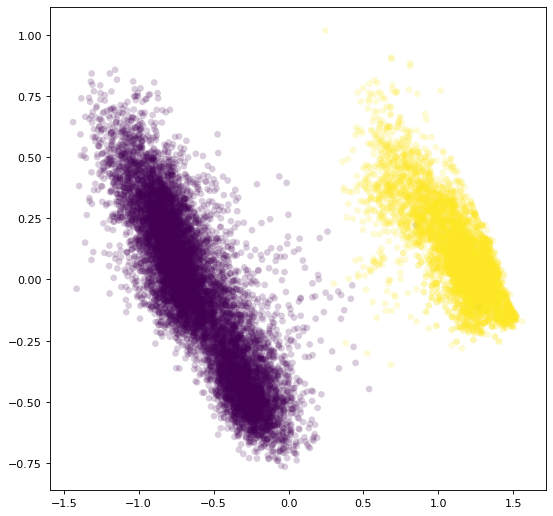

In [235]:
vals_pca_X_train = sklearn_pca.fit_transform(X_train_2)
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(vals_pca_X_train[:,0], vals_pca_X_train[:,1], c=Y_train, cmap='viridis', lw = 0, alpha=0.2)

The plot shows that the features are sufficient

In [236]:
start_time = time.time()
print ('Training...')
# Optimize parameters
def svc_param_selection(X, y, nfolds):
    Cs = [1, 10, 100]
    gammas = [0.1, 1, 10]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    return_param = grid_search.best_params_
    return return_param
param = svc_param_selection(X_train, Y_train, 5)
print ('Best parameters: ', param)

# Train a simple SVM 
clf = svm.SVC(**param)
clf.fit(X_train_2, Y_train)
print ('Model done. Time taken: ', time.time()-start_time)

Training...
Best parameters:  {'C': 10, 'gamma': 1}
Model done. Time taken:  8.82398796081543


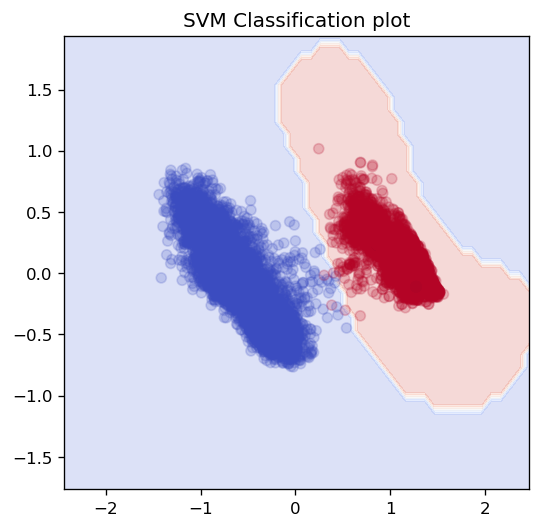

In [257]:
clf_temp = svm.SVC(**param)
clf_temp.fit(vals_pca_X_train, Y_train)
plt.figure(figsize=(5, 5), dpi=120)
x_min, x_max = vals_pca_X_train[:,0].min()-1, vals_pca_X_train[:,0].max()+1
y_min, y_max = vals_pca_X_train[:,1].min()-1, vals_pca_X_train[:,1].max()+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min, y_max, 0.1))
Z = clf_temp.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
#print (np.c_[xx.ravel(), yy.ravel()])


plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.2)
plt.scatter(vals_pca_X_train[:, 0], vals_pca_X_train[:, 1], c=Y_train, cmap=plt.cm.coolwarm, alpha=0.2)
plt.title('SVM Classification plot')
plt.show()

### Test the classifier with new strings

In [263]:
# positive testing 
test_1 = test[test['Y'] == 1].reset_index(drop = True)
data_inventory_1 = test_1['str_1'].tolist()+ data_inventory_2+\
['INTEL CORP.', '5 Time Square, New York, NY', 'Marks and Spencers Ltd.', 'Allentown, PA', 'Soeul, South Korea']
TESTING_STRING_POS = test_1['str_2'].tolist()+ \
['INTEL Corporation', '5 Time Square, NY, NY 10036', 'M&S Limited', 'Allentown, Pennsylvania', 'Soeul, SK']

# negative testing 
test_2 = test[test['Y'] == 0].reset_index(drop = True)
data_inventory_2 = pd.read_excel('../data/Book1.xlsx')['str_1'].tolist() 
TESTING_STRING_NEG = test_2['str_2'].unique().tolist()[:47]+['VYU/ 2890GUFY', 'AQUA LIFE INC.', 'desk']

In [264]:
len(TESTING_STRING_POS), len(TESTING_STRING_NEG)

(50, 50)

In [238]:
print (data_inventory_1)
print(data_inventory_2)

['Woodville, Texas', 'Headley Down, UK', '24 Mallory Way, Gourock, England', '934 Gerald XING, Edinburgh, England', '68814 8th Cir, Colton, Nevada 35654, USA', '0925 Troy Crossing, Ayr, ENG', 'Alexandria, SD', '71 Magdeline Dr, Runcorn, ENG', '2234 Loeprich Court, Attleborough, England', 'Hanslope, ENG, GB', '341 Trailsway Road, Wimborne Minster, ENG', 'Winfield, Alabama, United States', '1 Straubel Jct, Preston, ENG', 'Kingsbridge, England', '37 Vahlen Alley, Moosic, California', '04663 Boyd Hl, Powhatan, Kansas 13126, USA', '6669 American Hl Hill, Barnstaple, England', 'QUORUM HEALTH CORPORATION', '3 Sunnyside Trail, Fairhaven, PA', '2303 Oriole Point, Eaton, Minnesota', 'Walled Lake, MI', '071 Mockingbird Street, Mount Airy, PA 18286', '6 Raven Ctr, Breda, NY 98428', '7 Kingsford Pl, Fairview, AZ', '1548 Dryden Hl, Lancaster, ENG', 'LITHIA MOTORS, INC.', 'Thiells, New York, US', '15707 Messerschmidt Circle, Dakota City, TX 22981', '9601 Westport St, Westfield, VA', 'Buxton, ENG, Uni

In [239]:
testing_df = pd.DataFrame()
testing_df['str_1'] = data_inventory_1
testing_df = process_df(testing_df, col_list = ['str_1'], build_X = False)
testing_df_fnl = get_add_features(testing_df, col_list = ['str_1'], build_X = False)

def print_res(data_inv_df, testing_list, model, testing_type): 
    score = 0
    idx = 0
    for testing_str in testing_list: 
        data_inv_df['str_2'] = testing_str
        new_df = process_df(data_inv_df, ['str_2'], build_X = True)
        new_df_add = get_add_features(new_df, ['str_2'], build_X = True)
        X_test = get_combine_X(new_df, new_df_add)
        P = model.predict(X_test)
        new_df['predicted'] = P.tolist()
        entity_list = new_df[new_df.predicted==1]['str_1'].tolist() 
        if len(entity_list)>0: 
            print (testing_str, ':', entity_list)
        if P.sum() == 0: 
            print (testing_str, ':', 'NEW ENTITY!')
        if testing_type == 'positive' and len(entity_list) == 1:
            if entity_list[0] == testing_df.iat[idx, 0]: 
                score += 1
        if testing_type == 'negative' and len(entity_list) == 0:
            score += 1
        idx += 1
    return score

In [254]:
pos_ = print_res(testing_df_fnl, TESTING_STRING_POS, clf, 'positive') #good: clf, clf_tree

Woodville, Texas, United States : ['Woodville, Texas', 'San Benito, Texas, United States']
Headley Down, ENG, UK : ['Headley Down, UK']
24 Mallory Way, Gourock, England, LN6, GB : ['24 Mallory Way, Gourock, England']
934 Gerald XING, Edinburgh, England, LS6, GB : ['934 Gerald XING, Edinburgh, England']
68814 8th Circle, Colton, Nevada : ['68814 8th Cir, Colton, Nevada 35654, USA']
0925 Troy XING, Ayr, England : ['934 Gerald XING, Edinburgh, England', '0925 Troy Crossing, Ayr, ENG']
Alexandria, South Dakota, US : ['Alexandria, SD']
71 Magdeline Dr, Runcorn, England : ['71 Magdeline Dr, Runcorn, ENG']
2234 Loeprich Court, Attleborough, ENG : ['2234 Loeprich Court, Attleborough, England']
Hanslope, Great Britain : ['Hanslope, ENG, GB']
341 Trailsway Road, Wimborne Minster, ENG, SG4 : ['341 Trailsway Road, Wimborne Minster, ENG']
Winfield, AL : ['Winfield, Alabama, United States']
1 Straubel Junction, Preston, England : ['1 Straubel Jct, Preston, ENG']
Kingsbridge, ENG, UK : ['Kingsbridge,

In [265]:
testing_df_2 = pd.DataFrame()
testing_df_2['str_1'] = data_inventory_2
testing_df_2 = process_df(testing_df_2, col_list = ['str_1'], build_X = False)
testing_df_fnl_2 = get_add_features(testing_df_2, col_list = ['str_1'], build_X = False)
neg_ = print_res(testing_df_fnl_2, TESTING_STRING_NEG, clf, 'negative')

9513 Grover Terrace, Mitchell, NC 58255 : NEW ENTITY!
Spillville, IA, USA : NEW ENTITY!
09234 Dwight Jct, Sleaford, Scotland : ['ICNAO02312']
5 Parkside Pl, Silver Lake, CO 06459 : ['5 Time Sqaure, New York, NY 10036']
4 Emmet Center, Lake Linden, TX 15583 : ['5 Time Sqaure, New York, NY 10036', '213 35th Street, Sunrise, FL']
118 Warner Ctr, Port Ellen, England, DN36 : ['44 CHINA ROAD, KOWLOON, HONG KONG']
85984 Stoughton Way, Lytchett Matravers, England, GU32 : ['213 35th Street, Sunrise, FL']
Uig, UK : NEW ENTITY!
0 Lake Way Way, Staplehurst, England : ['Marks and Spencers Ltd']
Dover, ENG, UK : NEW ENTITY!
Brookneal, Virginia, US : NEW ENTITY!
1 Sullivan Point, South Cerney, WLS, SY4 : NEW ENTITY!
92 Graceland Pass, Sheerness, England : NEW ENTITY!
071 Anniversary Crossing, Ross, Florida : NEW ENTITY!
Portree, UK : NEW ENTITY!
Saint Francis, KS : NEW ENTITY!
03 Kingsford Drive, Borehamwood, SCT, IV1, UK : ['5 Time Sqaure, New York, NY 10036']
Southport, United Kingdom : ['United St

In [266]:
test_count = len(TESTING_STRING_POS+TESTING_STRING_NEG)
print ('Tested on',test_count, 'strings')
print ('Overall accuracy: ', (pos_+neg_)/test_count)

Tested on 100 strings
Overall accuracy:  0.78


In [267]:
pos_/len(TESTING_STRING_POS), neg_/len(TESTING_STRING_NEG)

(0.9, 0.66)